# Weatherization
This file shows the linear relationship between gas and htdd <br>
Compares the shifted versus non-shifted dates and demonstrates that shifting the dates is more accurate

In [11]:
import pandas as pd
import datetime as dt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt


In [12]:
#convert the date strings to date objects, for plotting
def toDate(series):
    return dt.datetime.strptime(series[:-13], '%Y-%m-%d')
def toDate2(series):
    return dt.datetime.strptime(series[:-9], '%Y-%m-%d')
#shift the year and month back by one to account for discrepencies in billing time
def shift_y(series):

    if series['Month'] == 1:
        return series['Year']-1
    else:
        return series['Year']
def shift_m(series):
    if series['Month'] == 1:
        return 12
    else:
        return series['Month']-1

In [13]:
df = pd.read_csv('~/Downloads/repairs_utilities_all_sqft.csv')
df['YearShift'] = df[['Year', 'Month']].apply(shift_y, axis=1)
df['MonthShift'] = df[['Year', 'Month']].apply(shift_m, axis=1)
df['ChargeDate'] = df['ChargeDate'].apply(toDate)

In [14]:
#read in weather
w0 = pd.read_csv("~/Dropbox/CDS-2019-AlbanyHub/ToDatabase/LCD_month.csv")
w = w0.loc[w0['YEAR']>=2012, :].copy()
w['DATE2'] = w['DATE'].apply(toDate2)

# Normalized by Days Per Month

In [15]:
#Get consumption and weather normalized by days per month
sr2 = df.loc[:, ['YearShift', 'MonthShift', 'ServiceType', 'address', 'ChargeAmount', 'Consumption']].groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'address'])
sr2 = sr2.sum().reset_index()
days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
w0['HTDD_norm'] = w0['HTDD']
w0['CLDD_norm'] = w0['CLDD']
sr2['Consumption_norm'] = sr2['Consumption']
#Also print months which have more than one record 
for y in range(2001, 2019):
    for m in range(1,13):
        record_w = w0.loc[(w0['YEAR']==y)&(w0['MONTH']==m), :]
        record_u = sr2.loc[(sr2['YearShift']==y)&(sr2['MonthShift']==m), :]
        if y%4 == 0:
            w0.loc[record_w.index, 'HTDD_norm'] = w0.loc[record_w.index, 'HTDD']/days_per_month_ly[m-1]
            w0.loc[record_w.index, 'CLDD_norm'] = w0.loc[record_w.index, 'CLDD']/days_per_month_ly[m-1]
            sr2.loc[record_u.index, 'Consumption_norm'] = sr2.loc[record_u.index, 'Consumption']/days_per_month_ly[m-1]
        else:
            w0.loc[record_w.index, 'HTDD_norm'] = w0.loc[record_w.index, 'HTDD']/days_per_month[m-1]
            w0.loc[record_w.index, 'CLDD_norm'] = w0.loc[record_w.index, 'CLDD']/days_per_month[m-1]
            sr2.loc[record_u.index, 'Consumption_norm'] = sr2.loc[record_u.index, 'Consumption']/days_per_month[m-1]

In [32]:
new_df = pd.merge(w0, sr2,  how='left', left_on=['YEAR', 'MONTH'], right_on=['YearShift','MonthShift'])
new_df_sub = new_df.loc[(new_df['YEAR']==2012) & (new_df['ServiceType']=='RGAS'), :]

In [36]:
x = np.array(new_df_sub['HTDD_norm'])
y = np.array(new_df_sub['Consumption_norm'])
b, m = polyfit(x, y, 1)
r2_score(y, m*x+b)

0.44742401495725403

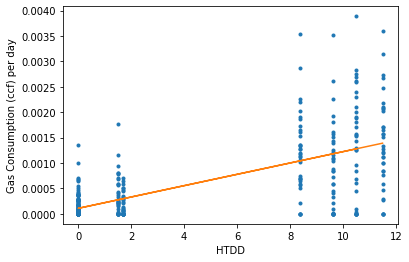

In [37]:
plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-' )
plt.ylabel("Gas Consumption (ccf) per day")
plt.xlabel("HTDD")
plt.show()

In [9]:
new_df.dropna().to_csv('~/Downloads/project_utilities_dateshift.csv', index=False)

# Normalized by Square Footage and Days Per Month


R2:  0.3993059511428275


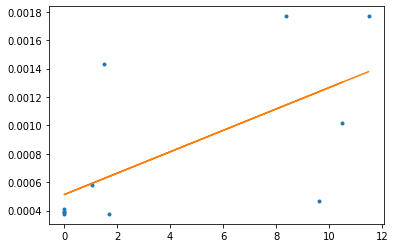

In [48]:
#Start with non-shifted months and look at the R-squared value for the relationship between htdd and gas consumption
#Get consumption and weather normalized by days per month
addr = '1211 E SOCIETY AVE'
sr2 = df.loc[:, ['Year', 'Month', 'ServiceType', 'address', 'ConsumptionPerSQFT']].groupby(by=['Year', 'Month', 'ServiceType', 'address'])
sr2 = sr2.sum().reset_index()
days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
w0['HTDD_norm'] = w0['HTDD']
w0['CLDD_norm'] = w0['CLDD']
sr2['Consumption_norm'] = sr2['ConsumptionPerSQFT']
#Also print months which have more than one record 
for y in range(2001, 2019):
    for m in range(1,13):
        record_w = w0.loc[(w0['YEAR']==y)&(w0['MONTH']==m), :]
        record_u = sr2.loc[(sr2['Year']==y)&(sr2['Month']==m), :]
        if y%4 == 0:
            w0.loc[record_w.index, 'HTDD_norm'] = w0.loc[record_w.index, 'HTDD']/days_per_month_ly[m-1]
            w0.loc[record_w.index, 'CLDD_norm'] = w0.loc[record_w.index, 'CLDD']/days_per_month_ly[m-1]
            sr2.loc[record_u.index, 'Consumption_norm'] = sr2.loc[record_u.index, 'ConsumptionPerSQFT']/days_per_month_ly[m-1]
        else:
            w0.loc[record_w.index, 'HTDD_norm'] = w0.loc[record_w.index, 'HTDD']/days_per_month[m-1]
            w0.loc[record_w.index, 'CLDD_norm'] = w0.loc[record_w.index, 'CLDD']/days_per_month[m-1]
            sr2.loc[record_u.index, 'Consumption_norm'] = sr2.loc[record_u.index, 'ConsumptionPerSQFT']/days_per_month[m-1]
new_df = pd.merge(w0, sr2,  how='left', left_on=['YEAR', 'MONTH'], right_on=['Year','Month']).dropna()
new_df_sub = new_df.loc[(new_df['YEAR']==2012) & (new_df['ServiceType']=='RGAS')& (new_df['address']== addr), :]
x = np.array(new_df_sub['HTDD_norm'])
y = np.array(new_df_sub['Consumption_norm'])
b, m = polyfit(x, y, 1)
print('R2: ',r2_score(y, m*x+b))
plt.plot(x, y, '.')
b, m = polyfit(x, y, 1)
plt.plot(x, m*x+b, '-' )
plt.show()

In [49]:
#Get consumption and weather normalized by days per month
sr2 = df.loc[:, ['YearShift', 'MonthShift', 'ServiceType', 'address', 'ConsumptionPerSQFT']].groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'address'])
sr2 = sr2.sum().reset_index()
days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
w0['HTDD_norm'] = w0['HTDD']
w0['CLDD_norm'] = w0['CLDD']
sr2['Consumption_norm'] = sr2['ConsumptionPerSQFT']
#Also print months which have more than one record 
for y in range(2001, 2019):
    for m in range(1,13):
        record_w = w0.loc[(w0['YEAR']==y)&(w0['MONTH']==m), :]
        record_u = sr2.loc[(sr2['YearShift']==y)&(sr2['MonthShift']==m), :]
        if y%4 == 0:
            w0.loc[record_w.index, 'HTDD_norm'] = w0.loc[record_w.index, 'HTDD']/days_per_month_ly[m-1]
            w0.loc[record_w.index, 'CLDD_norm'] = w0.loc[record_w.index, 'CLDD']/days_per_month_ly[m-1]
            sr2.loc[record_u.index, 'Consumption_norm'] = sr2.loc[record_u.index, 'ConsumptionPerSQFT']/days_per_month_ly[m-1]
        else:
            w0.loc[record_w.index, 'HTDD_norm'] = w0.loc[record_w.index, 'HTDD']/days_per_month[m-1]
            w0.loc[record_w.index, 'CLDD_norm'] = w0.loc[record_w.index, 'CLDD']/days_per_month[m-1]
            sr2.loc[record_u.index, 'Consumption_norm'] = sr2.loc[record_u.index, 'ConsumptionPerSQFT']/days_per_month[m-1]

In [50]:
new_df = pd.merge(w0, sr2,  how='left', left_on=['YEAR', 'MONTH'], right_on=['YearShift','MonthShift']).dropna()
new_df_sub = new_df.loc[(new_df['YEAR']==2012) & (new_df['ServiceType']=='RGAS')& (new_df['address']== addr), :]
new_df_sub.head()

,YEAR,MONTH,DATE,MonthlyMaximumTemperature,MonthlyMinimumTemperature,MonthlyMeanTemperature,CLDD,HTDD,HTDD_norm,CLDD_norm,YearShift,MonthShift,ServiceType,address,ConsumptionPerSQFT,Consumption_norm
384,2012,1,2012-01-31T23:59:00,68.4,41.3,54.9,11.0,356.0,11.483871,0.354839,2012.0,1.0,RGAS,1211 E SOCIETY AVE,0.051282,0.001654
584,2012,2,2012-02-29T23:59:00,68.2,46.1,57.2,16.0,243.0,8.379310,0.551724,2012.0,2.0,RGAS,1211 E SOCIETY AVE,0.044289,0.001527
784,2012,3,2012-03-31T23:59:00,80.7,55.6,68.2,145.0,47.0,1.516129,4.677419,2012.0,3.0,RGAS,1211 E SOCIETY AVE,0.017483,0.000564
986,2012,5,2012-05-31T23:59:00,89.7,65.4,77.6,389.0,0.0,0.000000,12.548387,2012.0,5.0,RGAS,1211 E SOCIETY AVE,0.011655,0.000376
1189,2012,6,2012-06-30T23:59:00,90.4,68.5,79.5,434.0,0.0,0.000000,14.466667,2012.0,6.0,RGAS,1211 E SOCIETY AVE,0.011655,0.000389


R2:  0.9241682474286985


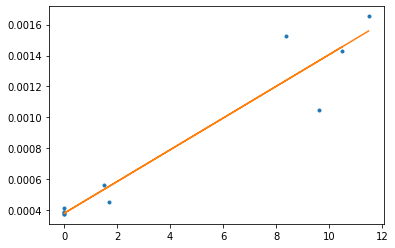

In [52]:
x = np.array(new_df_sub['HTDD_norm'])
y = np.array(new_df_sub['Consumption_norm'])
b, m = polyfit(x, y, 1)
print('R2: ',r2_score(y, m*x+b))
plt.plot(x, y, '.')
b, m = polyfit(x, y, 1)
plt.plot(x, m*x+b, '-' )
plt.show()
#Large improvement in R squared score for shifted versus non-shifted

#### Investigate by household (see which houses do not have a strong linear relationship between gas and htdd)

In [55]:
addresses = new_df['address'].unique()
non_fitted = []
fitted = []
no_data = []
#
for a in addresses:
    new_df = pd.merge(w0, sr2,  how='left', left_on=['YEAR', 'MONTH'], right_on=['YearShift','MonthShift']).dropna()
    new_df_sub = new_df.loc[(new_df['YEAR']==2012) & (new_df['ServiceType']=='RGAS') & (new_df['address']==a), :]
    if len(new_df_sub) == 0:
        no_data.append(a)
        continue
    x = np.array(new_df_sub['HTDD_norm'])
    y = np.array(new_df_sub['Consumption_norm'])
    b, m = polyfit(x, y, 1)
    if r2_score(y, m*x+b) < 0.75:
        print(a, ", R squared:", r2_score(y, m*x+b))
        non_fitted.append(a)
    else:
        fitted.append(a)

1817 GREENVALE AVE , R squared: 0.38537580491784673
1904 GILLESPIE AVE , R squared: 0.5473878326317356
2020 N RIVERVIEW CIR , R squared: 0.5497472330696151
2316 HEMLOCK DR , R squared: 0.3224904941994625
630 12TH AVE , R squared: 0.49916659317283796
903 DON CUTLER SR DR , R squared: 0.3217678833629467


In [131]:
new_df.to_csv('~/Downloads/project_utilities_dateshift_persqft.csv', index=False)

# Normalized by Square Footage and Days Per Month, minus zero values

In [227]:
#Try to drop addresses with a lot of missing consumption values
df_no0 = new_df[new_df['Consumption_norm']>0]
new_df_sub = df_no0.loc[(df_no0['YEAR']==2012) & (df_no0['ServiceType']=='RELC'), :]
new_df_sub.shape

(591, 17)

In [223]:
x = np.array(new_df_sub['HTDD_norm'])
y = np.array(new_df_sub['Consumption_norm'])
b, m = polyfit(x, y, 1)
r2_score(y, m*x+b)

0.48758403246352666

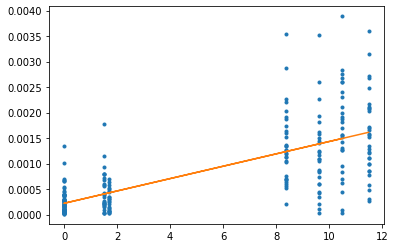

In [224]:
x = np.array(new_df_sub['HTDD_norm'])
y = np.array(new_df_sub['Consumption_norm'])
plt.plot(new_df_sub['HTDD_norm'], new_df_sub['Consumption_norm'], '.')

plt.plot(x, m*x+b, '-' )
plt.show()

In [200]:
r2_score(y, m*x+b)

0.44597255062541064

In [176]:
df_no0[(df_no0['address']=='923 W GORDON AVE') & (df_no0['ServiceType']=='RELC')]#.sort_values(by=['Year', 'Month'])

,YEAR,MONTH,DATE,MonthlyMaximumTemperature,MonthlyMinimumTemperature,MonthlyMeanTemperature,AWND,CLDD,HTDD,HTDD_norm,CLDD_norm,YearShift,MonthShift,ServiceType,address,ChargeAmount,Consumption,Consumption_norm
183,2011,12,NaN,67.400000,43.166667,55.466667,5.130000,13,299,9.645161,0.419355,2011.0,12.0,RELC,923 W GORDON AVE,94.82,991.0,31.967742
383,2012,1,2012-01-31T23:59:00,68.400000,41.300000,54.900000,5.400000,11,356,11.483871,0.354839,2012.0,1.0,RELC,923 W GORDON AVE,89.18,922.0,29.741935
583,2012,2,2012-02-29T23:59:00,68.200000,46.100000,57.200000,6.000000,16,243,8.379310,0.551724,2012.0,2.0,RELC,923 W GORDON AVE,90.30,841.0,29.000000
783,2012,3,2012-03-31T23:59:00,80.700000,55.600000,68.200000,5.600000,145,47,1.516129,4.677419,2012.0,3.0,RELC,923 W GORDON AVE,78.92,716.0,23.096774
985,2012,5,2012-05-31T23:59:00,89.700000,65.400000,77.600000,4.900000,389,0,0.000000,12.548387,2012.0,5.0,RELC,923 W GORDON AVE,131.84,1142.0,36.838710
1188,2012,6,2012-06-30T23:59:00,90.400000,68.500000,79.500000,6.500000,434,0,0.000000,14.466667,2012.0,6.0,RELC,923 W GORDON AVE,173.80,1494.0,49.800000
1390,2012,7,2012-07-31T23:59:00,95.200000,73.300000,84.300000,5.100000,596,0,0.000000,19.225806,2012.0,7.0,RELC,923 W GORDON AVE,186.07,1597.0,51.516129
1592,2012,8,2012-08-31T23:59:00,89.200000,71.900000,80.600000,4.700000,482,0,0.000000,15.548387,2012.0,8.0,RELC,923 W GORDON AVE,143.77,1242.0,40.064516
1794,2012,9,2012-09-30T23:59:00,87.900000,66.700000,77.300000,4.000000,368,0,0.000000,12.266667,2012.0,9.0,RELC,923 W GORDON AVE,113.99,986.0,32.866667
1996,2012,10,2012-10-31T23:59:00,79.200000,56.100000,67.700000,4.900000,136,53,1.709677,4.387097,2012.0,10.0,RELC,923 W GORDON AVE,87.39,796.0,25.677419


# Try with random households rather than projects

In [10]:
df = pd.read_csv('~/Downloads/utilities_sqft.csv')
df['YearShift'] = df[['Year', 'Month']].apply(shift_y, axis=1)
df['MonthShift'] = df[['Year', 'Month']].apply(shift_m, axis=1)
#df['ChargeDate'] = df['ChargeDate'].apply(toDate)

In [11]:
#Get consumption and weather normalized by days per month
sr2 = df.loc[:, ['ServiceType', 'address', 'YearShift', 'MonthShift', 'Consumption', 'ConsumptionPerSQFT','DaysOfService']].groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'address'])
sr2 = sr2.sum().reset_index()
days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
w0['HTDD_norm'] = w0['HTDD']
w0['CLDD_norm'] = w0['CLDD']
sr2['Consumption_norm'] = sr2['Consumption']
sr2['Consumption_norm_SQFT'] = sr2['ConsumptionPerSQFT']
#Also print months which have more than one record 
for y in range(2001, 2019):
    for m in range(1,13):
        record_w = w0.loc[(w0['YEAR']==y)&(w0['MONTH']==m), :]
        record_u = sr2.loc[(sr2['YearShift']==y)&(sr2['MonthShift']==m), :]
        if y%4 == 0:
            w0.loc[record_w.index, 'HTDD_norm'] = w0.loc[record_w.index, 'HTDD']/days_per_month_ly[m-1]
            w0.loc[record_w.index, 'CLDD_norm'] = w0.loc[record_w.index, 'CLDD']/days_per_month_ly[m-1]
            sr2.loc[record_u.index, 'Consumption_norm'] = sr2.loc[record_u.index, 'Consumption']/days_per_month_ly[m-1]
            sr2.loc[record_u.index, 'Consumption_norm_SQFT'] = sr2.loc[record_u.index, 'ConsumptionPerSQFT']/days_per_month_ly[m-1]
        else:
            w0.loc[record_w.index, 'HTDD_norm'] = w0.loc[record_w.index, 'HTDD']/days_per_month[m-1]
            w0.loc[record_w.index, 'CLDD_norm'] = w0.loc[record_w.index, 'CLDD']/days_per_month[m-1]
            sr2.loc[record_u.index, 'Consumption_norm'] = sr2.loc[record_u.index, 'Consumption']/days_per_month[m-1]
            sr2.loc[record_u.index, 'Consumption_norm_SQFT'] = sr2.loc[record_u.index, 'ConsumptionPerSQFT']/days_per_month[m-1]

In [30]:
new_df = pd.merge(w0, sr2,  how='left', left_on=['YEAR', 'MONTH'], right_on=['YearShift','MonthShift']).dropna()
addr = '1001 SAINT ANDREWS DR'
new_df_sub = new_df.loc[(new_df['YEAR']==2012) & (new_df['ServiceType']=='RGAS')& (new_df['address']==addr), :]

In [33]:
x = np.array(new_df_sub['HTDD_norm'])
y = np.array(new_df_sub['Consumption_norm'])
b, m = polyfit(x, y, 1)
r2_score(y, m*x+b)

0.7551972214464757

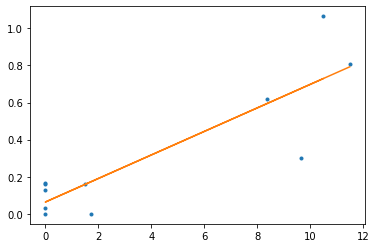

In [34]:
x = np.array(new_df_sub['HTDD_norm'])
y = np.array(new_df_sub['Consumption_norm'])
plt.plot(new_df_sub['HTDD_norm'], new_df_sub['Consumption_norm'], '.')

plt.plot(x, m*x+b, '-' )
plt.show()

In [26]:
gp = sr2[(sr2['ServiceType']=='RGAS') & (sr2['YearShift']==2012)].groupby(by="address").count()
addresses = gp['YearShift']>=11

,YearShift,MonthShift,ServiceType,Consumption,ConsumptionPerSQFT,DaysOfService,Consumption_norm,Consumption_norm_SQFT
address,,,,,,,,
100 ALMOND DR,11,11,11,11,11,11,11,11
100 FORD ST,11,11,11,11,11,11,11,11
100 S INGLESIDE DR,11,11,11,11,11,11,11,11
1000 10TH AVE,11,11,11,11,11,11,11,11
1000 11TH AVE,11,11,11,11,11,11,11,11
1000 7TH AVE,11,11,11,11,11,11,11,11
1000 9TH AVE,11,11,11,11,11,11,11,11
1000 AUGUSTA DR,11,11,11,11,11,11,11,11
1000 E ROOSEVELT AVE,11,11,11,11,11,11,11,11
